# Rule-Based Grasp Detection v3

**ระบบ Grasp Detection แบบ Rule-Based ที่เรียบง่ายและเชื่อถือได้**

- ✅ ไม่ใช้ ML Grasp Model (รวดเร็วกว่า)
- ✅ จุดจับอยู่ใน Object เสมอ (Reliable)
- ✅ ปรับแต่งง่าย (Config-based)
- ✅ Debug ง่าย (Clear Rules)

## 1. Imports and Setup

In [ ]:
!pip install torch torchvision opencv-python numpy ultralytics

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

# Import modules
import config
from object_detector import ObjectDetector
from depth_estimator import DepthEstimator
from rule_based_grasp import RuleBasedGraspGenerator
from simple_pipeline import SimplePipeline
from visualization import (
    draw_bounding_boxes,
    draw_grasps,
    create_depth_colormap,
    create_side_by_side,
    add_info_text,
    save_result
)

print("✓ Imports loaded")
print(f"Mode: {config.OPERATING_MODE}")
print(f"Capture: {config.CAPTURE_MODE}")
print(f"Device: {config.DEVICE}")

[Config] Mode: ROBOT, Capture: FRAME_BY_FRAME, Device: cpu


xFormers not available
xFormers not available


✓ Imports loaded
Mode: ROBOT
Capture: FRAME_BY_FRAME
Device: cpu


## 2. Load Models

In [2]:
print("Loading models...\n")

# 1. Object Detector
print("[1/2] Object Detector (YOLOv8)")
object_detector = ObjectDetector(
    model_name=config.YOLO_MODEL,
    confidence_threshold=config.CONFIDENCE_THRESHOLD,
    device=config.DEVICE
)
object_detector.load_model()

# 2. Depth Estimator
print("\n[2/2] Depth Estimator (DepthAnything V2)")
depth_estimator = DepthEstimator(
    model_name=config.DEPTH_MODEL,
    device=config.DEVICE
)
depth_estimator.load_model(config.DEPTH_MODEL_PATH)

# 3. Grasp Generator (no model to load!)
grasp_generator = RuleBasedGraspGenerator(config)

# 4. Create Pipeline
pipeline = SimplePipeline(config)
pipeline.set_components(object_detector, depth_estimator, grasp_generator)

print("\n" + "="*60)
print("✓ All components ready!")
print("="*60)

Loading models...

[1/2] Object Detector (YOLOv8)
Loading yolov8n...
✓ Object detector loaded on cpu

[2/2] Depth Estimator (DepthAnything V2)
Loading DepthAnything V2 (vits)...
✓ Depth model loaded on cpu

✓ All components ready!


## 3. Settings

In [3]:
# Runtime settings
ENABLE_OBJECT_DETECTION = True
SHOW_PANELS = True

print(f"Object Detection: {ENABLE_OBJECT_DETECTION}")
print(f"Show Panels: {SHOW_PANELS}")

Object Detection: True
Show Panels: True


## 4. Single Frame Test

Frame captured: (480, 640, 3)

Processing...

Results:
  Objects: 2
  person: 4 grasps
    Grasp 1: angle=90°, quality=0.447
    Grasp 2: angle=135°, quality=0.253
    Grasp 3: angle=45°, quality=0.057
    Grasp 4: angle=0°, quality=0.007
  laptop: 4 grasps
    Grasp 1: angle=90°, quality=0.007
    Grasp 2: angle=0°, quality=0.004
    Grasp 3: angle=135°, quality=0.001
    Grasp 4: angle=45°, quality=0.000

Timing:
  object_detection: 47.4 ms
  depth_estimation: 1077.9 ms
  grasp_generation: 0.8 ms
  total: 1126.1 ms


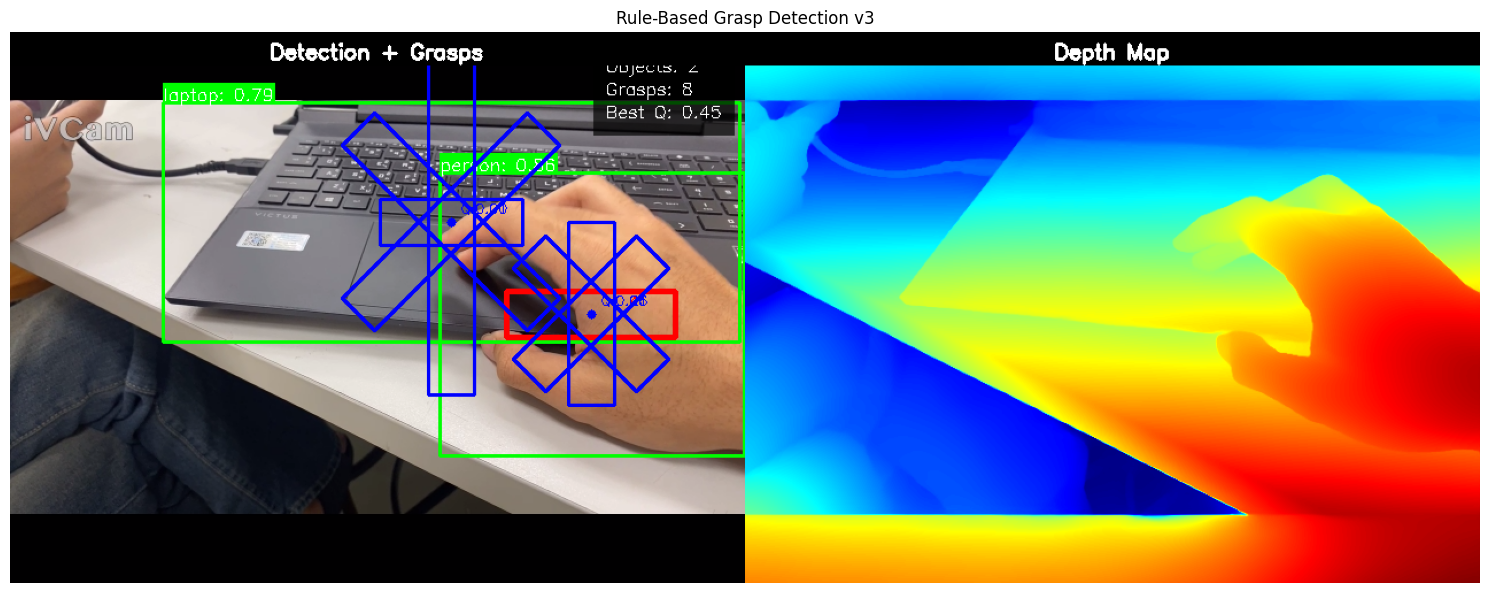

Saved: results\20251126_161008_test_result.png


In [6]:
# Capture frame
cap = cv2.VideoCapture(config.CAMERA_ID)
ret, frame = cap.read()
cap.release()

if ret:
    print(f"Frame captured: {frame.shape}")
    
    # Process
    print("\nProcessing...")
    result = pipeline.process_frame(frame, detect_objects=ENABLE_OBJECT_DETECTION)
    
    # Results
    print(f"\nResults:")
    print(f"  Objects: {len(result['detections'])}")
    
    total_grasps = 0
    for det in result['detections']:
        grasps = det['grasps']
        total_grasps += len(grasps)
        print(f"  {det['class_name']}: {len(grasps)} grasps")
        
        # Show grasp details
        for i, g in enumerate(grasps):
            print(f"    Grasp {i+1}: angle={np.degrees(g.angle):.0f}°, quality={g.quality:.3f}")
    
    print(f"\nTiming:")
    for key, value in result['timing'].items():
        print(f"  {key}: {value*1000:.1f} ms")
    
    # Visualize
    vis = frame.copy()
    
    # Draw bounding boxes
    if ENABLE_OBJECT_DETECTION:
        vis = draw_bounding_boxes(vis, result['detections'])
    
    # Draw all grasps
    all_grasps = pipeline.get_all_grasps(result)
    best_grasp = pipeline.get_best_grasp(result)
    
    if all_grasps:
        vis = draw_grasps(vis, all_grasps, best_grasp=best_grasp)
    
    # Add info
    info = {
        'Objects': len(result['detections']),
        'Grasps': total_grasps,
        'Best Q': f"{best_grasp.quality:.2f}" if best_grasp else "N/A"
    }
    vis = add_info_text(vis, info, position='top-right')
    
    # Show
    if SHOW_PANELS:
        depth_vis = create_depth_colormap(result['depth_map'])
        display = create_side_by_side([vis, depth_vis], ["Detection + Grasps", "Depth Map"])
    else:
        display = vis
    
    plt.figure(figsize=(15, 8))
    plt.imshow(cv2.cvtColor(display, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Rule-Based Grasp Detection v3')
    plt.tight_layout()
    plt.show()
    
    # Save
    if config.SAVE_RESULTS:
        save_result(display, "test_result.png")
else:
    print("Error capturing frame")

## 5. Interactive Mode

**Controls:**
- `SPACE`: Capture (Frame-by-Frame mode)
- `O`: Toggle object detection
- `S`: Save result
- `Q`: Quit

In [ ]:
cap = cv2.VideoCapture(config.CAMERA_ID)

if not cap.isOpened():
    print("Error: Could not open camera")
else:
    print("Camera started!")
    print("Controls: SPACE=capture, O=toggle detection, S=save, Q=quit")
    
    use_detection = ENABLE_OBJECT_DETECTION
    last_result = None
    frame_count = 0
    
    # For frame-by-frame mode
    frame_ready = False
    current_frame = None
    
    try:
        while True:
            # Read frame
            ret, frame = cap.read()
            if not ret:
                break
            
            display_frame = frame.copy()
            
            # Check mode
            if config.CAPTURE_MODE == 'REALTIME':
                # Process every frame
                result = pipeline.process_frame(frame, detect_objects=use_detection)
                last_result = result
                frame_count += 1
            
            elif config.CAPTURE_MODE == 'FRAME_BY_FRAME':
                # Only process when triggered
                if frame_ready:
                    result = pipeline.process_frame(current_frame, detect_objects=use_detection)
                    last_result = result
                    frame_count += 1
                    frame_ready = False
            
            # Visualize
            if last_result:
                vis = display_frame.copy()
                
                if use_detection:
                    vis = draw_bounding_boxes(vis, last_result['detections'])
                
                all_grasps = pipeline.get_all_grasps(last_result)
                best_grasp = pipeline.get_best_grasp(last_result)
                
                if all_grasps:
                    vis = draw_grasps(vis, all_grasps, best_grasp=best_grasp)
                
                info = {
                    'Objects': len(last_result['detections']),
                    'Grasps': len(all_grasps),
                    'Frames': frame_count
                }
                vis = add_info_text(vis, info)
                
                display_frame = vis
            
            # Add mode info
            mode_text = f"Mode: {config.CAPTURE_MODE}"
            cv2.putText(display_frame, mode_text, (10, 30),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
            
            det_text = f"Detection: {'ON' if use_detection else 'OFF'}"
            cv2.putText(display_frame, det_text, (10, 60),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 1)
            
            cv2.imshow('Rule-Based Grasp v3', display_frame)
            
            # Handle keys
            key = cv2.waitKey(1) & 0xFF
            
            if key == ord('q'):
                break
            elif key == ord(' '):  # Space - capture frame
                current_frame = frame.copy()
                frame_ready = True
                print("Frame captured!")
            elif key == ord('o'):  # Toggle detection
                use_detection = not use_detection
                print(f"Detection: {'ON' if use_detection else 'OFF'}")
            elif key == ord('s'):  # Save
                if last_result:
                    save_result(display_frame, f"capture_{frame_count}.png")
    
    finally:
        cap.release()
        cv2.destroyAllWindows()
        print(f"\nStopped. Frames processed: {frame_count}")

## 6. Statistics

In [ ]:
stats = pipeline.get_stats()

print("Pipeline Statistics:")
print("="*40)
for key, value in stats.items():
    print(f"{key:20s}: {value}")
print("="*40)